## TASK C Data Visualization using Matplot Lib

### 1.  Streaming Visualization 

The data consumed from producer1 will be plotted using line graph. The two pointers shows the maximum and the minimum values of the air temperature celcius. The window of 6 records is considered, so once the 6th record arrives, for the next upcoming records the 1st record will be popped.<br>

#### Note: The streaming visualization will run until producer1 is stopped, to continue to static visualization, stop producer1.

<IPython.core.display.Javascript object>


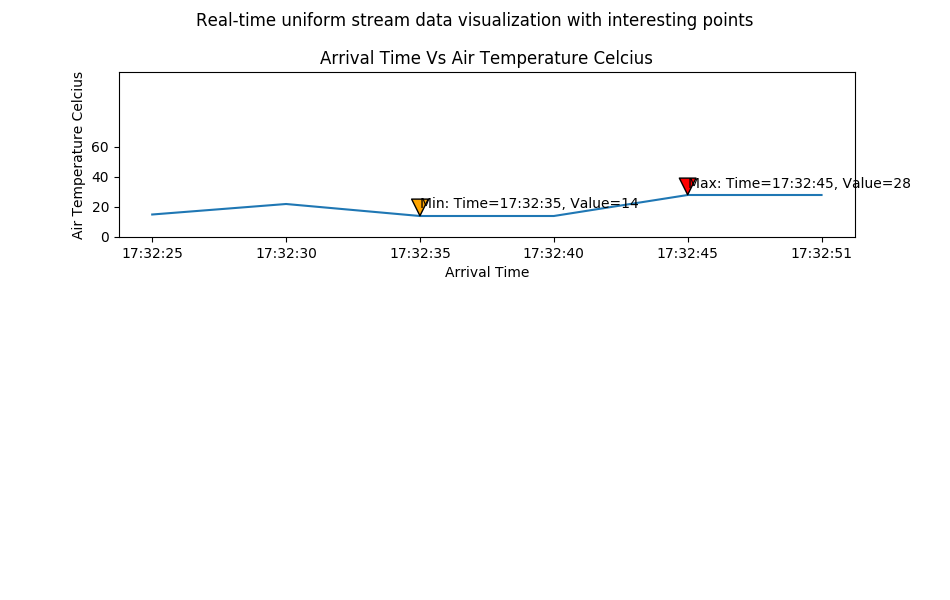

Waiting for messages


In [1]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import ast

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'Scenario01'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   # auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)
        ax1 = fig.add_subplot(211)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Value')
        ax1.title.set_text('Creation Time Vs Value')
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax1
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax1):
    try:
        # container for x and y values
        x1, y1 = [], []
        print('Waiting for messages')
        
        for message in consumer:
            s = message.value.decode('utf-8').split('\"')
            data = s[0]
            data = ast.literal_eval(data)
            if data["id"]=='sender_1':
                x1.append(dt.datetime.now().strftime("%X")) 
                y1.append(int(data['air_temperature_celcius']))
                ax1.clear()
                ax1.plot(x1, y1)
                ax1.set_xlabel('Arrival Time')
                ax1.set_ylabel('Air Temperature Celcius')
                ax1.set_title('Arrival Time Vs Air Temperature Celcius')
                ax1.set_ylim(0,110) 
                ax1.set_yticks([0,20,40,60])
                annotate_max(x1, y1, ax1)
                annotate_min(x1, y1, ax1)       
                fig.canvas.draw()
                if(len(x1)>5):
                    x1.pop(0) # removing the item in the first position
                    y1.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax1 = init_plots()
    consume_messages(consumer, fig, ax1)
    
    

### 2. Static Visualization 

In [2]:
from pymongo import MongoClient
import pandas as pd
#initialising Db connections
client = MongoClient()
db = client.fit5148_db
climate = db.climate

Once the streaming application stops and all the records are stored in the collection 'climate', the static plot of top 10 number of fires at given time is plotted using bar plot.

In [3]:
#Quering to find number of fires for each time
fires=db.climate.aggregate([{'$unwind':'$fire_record'},
                {'$group':{
                    '_id':'$fire_record.time',
                    'Time':{'$first':'$fire_record.time'},
                    'Total Fires':{'$sum':1},
                    
                }},{'$sort': {'Total Fires': -1}},
                {
                    '$project':{'_id':0}
                },{"$limit":10}
                           ])

In [4]:
#Plotting Bar Graph 
fire_count=[]
for each in fires:
    fire_count.append(each)
Fire_df=pd.DataFrame(fire_count)

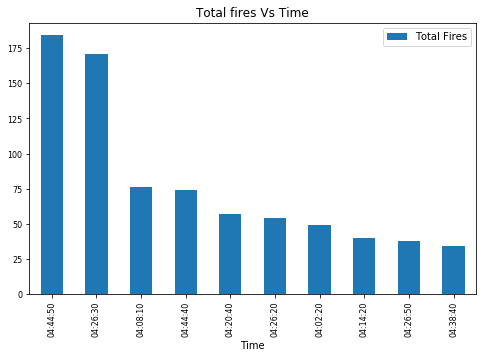

In [7]:
Fire_df.plot(kind='bar',x='Time',y='Total Fires',title='Total fires Vs Time',figsize=(8,5),fontsize=8)

Plotting the marker location based on the fire records updated in the collection.

In [6]:
from gmplot import gmplot
from pymongo import MongoClient
import webbrowser

# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.966, 145.05100000000002, 10)

# Scatter points
latlog=[]
for row in climate.aggregate([{"$unwind":"$fire_record"}]):
    gmap.marker(float(row['fire_record']['latitude']), float(row['fire_record']['longitude']),'#FF4500',
                title="Surface Temperature :"+str(row['fire_record']['surface_temperature_celcius'])+
                ", Confidence:"+str(row['fire_record']['confidence'])+", Air temperature:"+str(row['air_temperature_celcius'])+
                ", Relative Humidity:"+str(row['relative_humidity'])
               
               )

# Drawing the mapz
gmap.draw("FireLocations.html")
webbrowser.open_new("FireLocations.html")

True